In [1]:
import sys
import matplotlib.pyplot as plt
import os

args = 1
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

from load_dataset import TimeSeries
import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk
import pandas as pd

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel
plt.style.use('Solarize_Light2')

Selected GPU 1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullLatentGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod

In [9]:
readname = 'nile'
savename = "nile"
path = f'./{savename}'
# os.mkdir(path)

FileExistsError: [Errno 17] File exists: './nile'

100


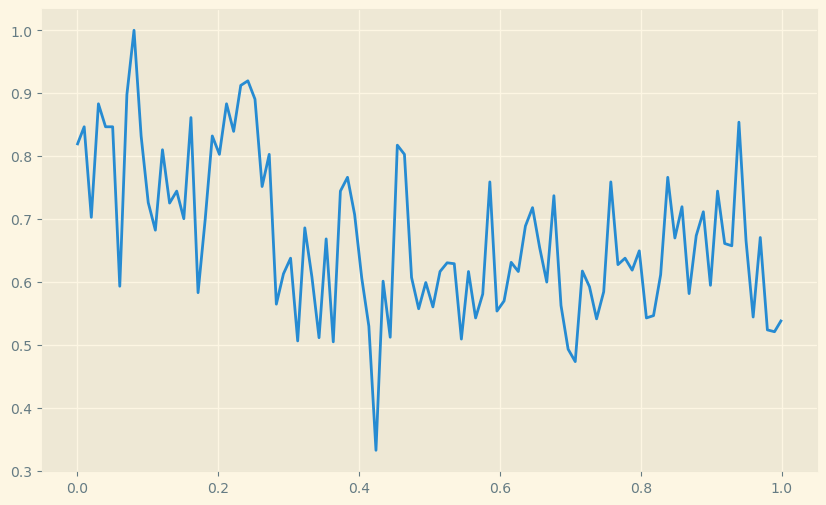

In [10]:
data = TimeSeries.from_json(f'datasets/{readname}/{readname}.json')
fig = plt.figure(figsize = (10, 6))
# y_data = data.y[15:]
print(len(data.y))
# x_data = data.t[15:]-15
corr_data = data.y/jnp.max(data.y)
plt.plot(data.t/(len(data.t)-1), corr_data)

# plt.savefig(f"{savename}/{savename}_data")


In [144]:
key = jrnd.PRNGKey(123456)

size = 10
T = 1
max_CP = size
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)

priors = dict(kernel=dict(
                          # lengthscale=Uniform_mod(low = jnp.zeros(max_CP),
                          #                       high = jnp.zeros(max_CP)+1),
                          # variance=Uniform_mod(low = jnp.zeros(max_CP),
                          #                       high = jnp.zeros(max_CP)+5),
                          lengthscale=LogNormal_mod(0, 2, max_CP+1),
                          variance=LogNormal_mod(0, 2, max_CP+1), 
                        #   lengthscale=dx.Transformed(dx.MultivariateNormalFullCovariance(jnp.zeros(max_CP),
                        #                                                                  jnp.eye(max_CP)), 
                        #                              dx.Block(tfb.Exp(), 1)),
                        #   variance=dx.Transformed(dx.MultivariateNormalFullCovariance(jnp.zeros(max_CP),
                        #                                                               jnp.eye(max_CP)),
                        #                           dx.Block(tfb.Exp(), 1)),
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())))

x = jnp.array(data.t/(len(data.t)-1))[:, jnp.newaxis]
y = corr_data.flatten()
# gp_latent = FullLatentGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

# num_particles = 1000
# num_mcmc_steps = 100

In [145]:
from fullgp import FullLatentGPModelhyper_mult
gp_latent = FullLatentGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1000
num_mcmc_steps = 100

key, gpl_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                mode='gibbs-in-smc',
                                                                sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps), 
                                                                poisson = True)

In [56]:
# jnp.save(f"{savename}/test.npy", lgp_particles.particles)
# test = jnp.load("test.npy", allow_pickle=True)[()]
# test

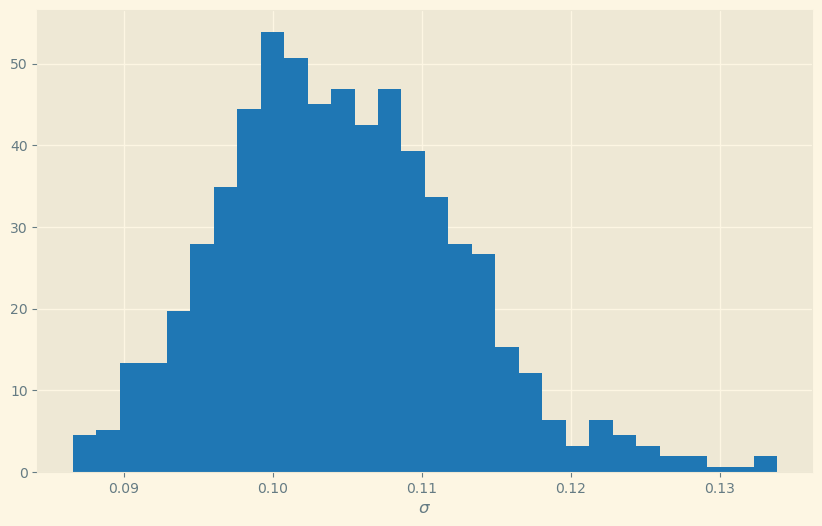

In [76]:
plt.style.use('Solarize_Light2')
fig = plt.figure(figsize = (10, 6))
pd = lgp_particles.particles['likelihood']['obs_noise']
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
plt.hist(pd, bins=30, density=True, color='tab:blue')
# plt.set_ylabel('obs_noise', rotation=0, ha='right')
plt.xlabel(r'${:s}$'.format('\sigma'))
plt.show()

Text(0, 0.5, 'variance')

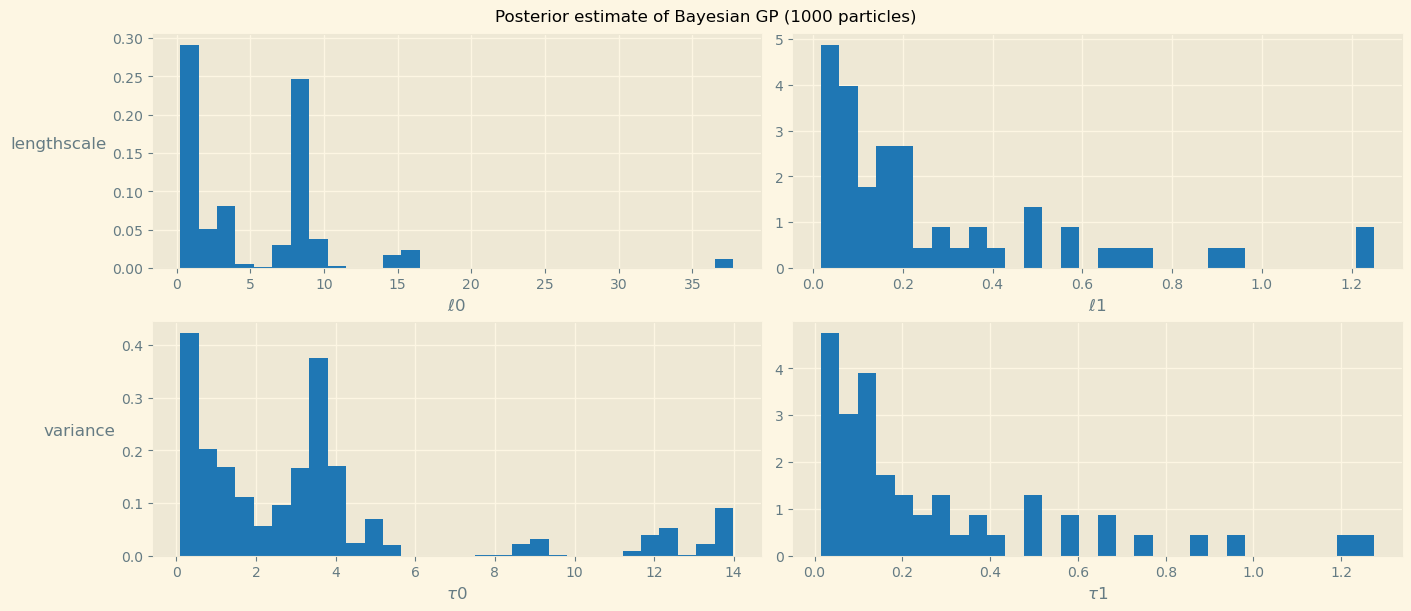

In [146]:
trainables = ['lengthscale', 'variance']

num_params = len(trainables)

symbols = dict(lengthscale='\ell',
            variance=r'\tau')
max_CP = 1

_, axes = plt.subplots(nrows=num_params, ncols=max_CP+1, constrained_layout=True,
                    figsize=(14, 6))


# particles = mgp_particles
tr = dict(lengthscale=lgp_particles.particles['kernel']['lengthscale'],
            variance=lgp_particles.particles['kernel']['variance'],
            )
            
for j, var in enumerate(trainables):
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    for i in range(max_CP+1):
      axes[j, i].hist(pd[:, i][~jnp.isnan(pd[:, i])], bins=30, density=True, color='tab:blue')
      # axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

      if var in symbols:
          axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))


num_particles = 1000
plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')

# plt.savefig(f"{savename}/{savename}_posteriors_scale1_10_var3_scale2_50000")

In [70]:
idx = jnp.round(jnp.linspace(0, len(data.datestr) - 1, 8)).astype(int)
labels = data.datestr[idx]
indices = jnp.linspace(0, 1, 8)
print(labels)
print(indices)

['1871' '1885' '1899' '1913' '1928' '1942' '1956' '1970']
[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]


Text(0, 0.5, 'Volume at Aswan\nnile')

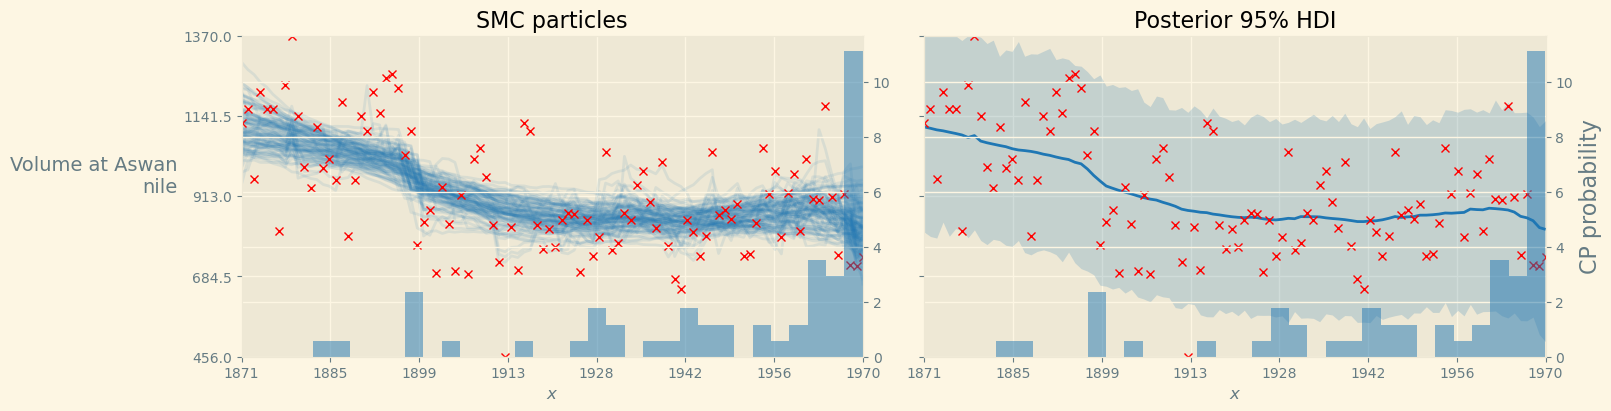

In [147]:
x_pred = jnp.linspace(0, 1, num=100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_latent.predict_f(key_pred, x_pred)

pd = lgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)


ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
obs_noise = lgp_particles.particles['likelihood']['obs_noise']
f_mean = jnp.nanmean(f_pred, axis=0)
y_pred = gp_latent.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = f_mean - 1.96*jnp.mean(obs_noise)
# f_hdi_upper = f_mean + 1.96*jnp.mean(obs_noise)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    # ax.plot(qc1.t, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([0, 1])
    ax.set_ylim([jnp.min(corr_data), jnp.max(corr_data)])
    ax.set_xticks(indices, labels = labels)
    ax.set_yticks(jnp.linspace(jnp.min(corr_data), jnp.max(corr_data), 5), labels = jnp.round(jnp.linspace(jnp.min(data.y), jnp.max(data.y), 5), 3))
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel(f"{data.columns[0]}" "\n" f"{readname}", rotation=0, ha='right', fontsize=14)

# plt.savefig(f"{savename}/{savename}_fit_scale1_10_var3_scale2_50000")

Text(0, 0.5, 'Amount of particles')

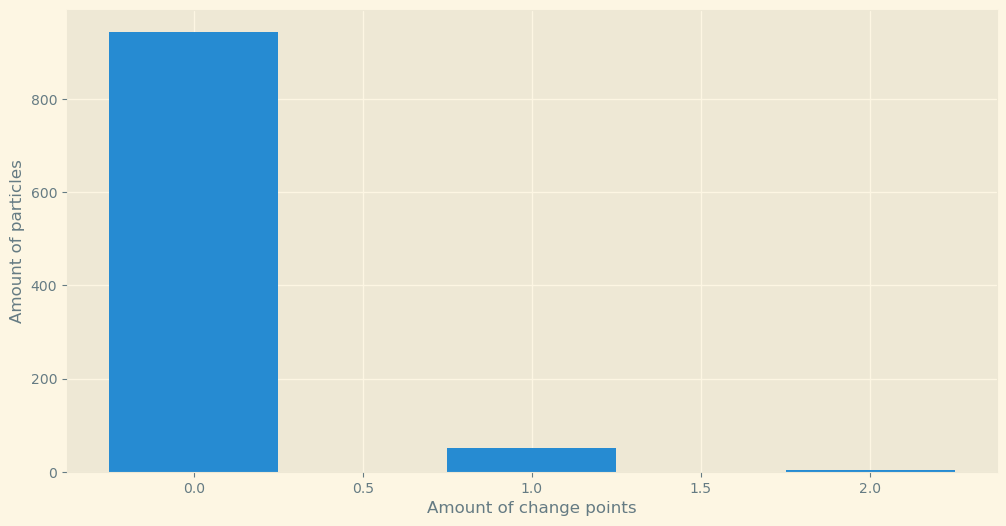

In [148]:
fig = plt.figure(figsize=(12, 6))
num_val = lgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")

# plt.savefig(f"{savename}/{savename}_#CP_scale1_10_var3_scale2_50000")

In [97]:
params = dict(lengthscale = lgp_particles.particles['kernel']['lengthscale'][0],
              variance = lgp_particles.particles['kernel']['variance'][0],
              num = lgp_particles.particles['kernel']['num'][0]
              )

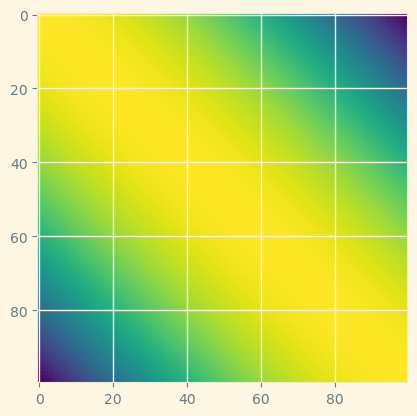

In [98]:
# plt.plot(jnp.mean(lgp_particles.particles['f'], axis = 0))
# plt.plot(f_mean)
# plt.ylim([jnp.min(corr_data), jnp.max(corr_data)])
x = jnp.linspace(0, 1, 100)[:, jnp.newaxis]
K = gp_latent.cov_fn.cross_covariance(params, x, x)
plt.imshow(K)

[0.3 nan nan nan nan nan nan nan nan nan]
[1.12968454 1.12968454        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
[1.81796494 1.81796494        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
-843.0674545446858
[0.3 nan nan nan nan nan nan nan nan nan]
[1.10474588 1.10474588        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
[1.66685343 1.66685343        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
-84.72454352379953
[0.3 nan nan nan nan nan nan nan nan nan]
[1.12215287 1.12215287        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
[1.78437889 1.78437889        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
33.47484726162196


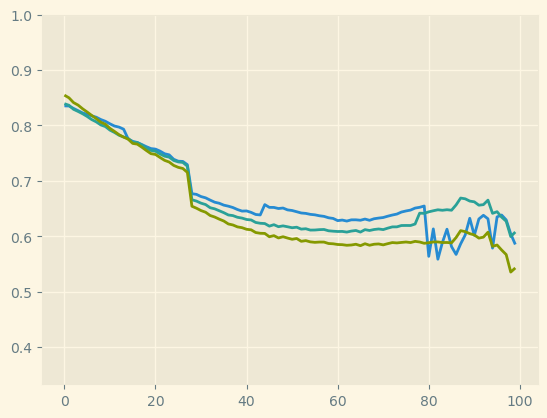

In [143]:
from uicsmodels.gaussianprocesses.meanfunctions import Zero

samples = gp_latent.get_monte_carlo_samples()
min = 182
max = 185
for i in range(min, max):
    plt.plot(samples['f'][i])
    # print(samples['kernel']['lengthscale'][i])
    # print(samples['kernel']['variance'][i])
    # print(samples['kernel']['num'][i])
    num = samples['kernel']['num'][i]
    new_num = num.at[0].set(0.3)
    print(new_num)
    l = samples['kernel']['lengthscale'][i]
    new_l = l.at[1].set(l[0])
    print(new_l)
    v = samples['kernel']['variance'][i]
    new_v = v.at[1].set(v[0])
    print(new_v)
    f = samples['f'][i]
    params = dict(lengthscale = new_l,
              variance = new_v,
              num = new_num
              )
    mu = Zero().mean(params=None, x=x)
    jitter = 1e-5
    cov_ = gp_latent.cov_fn.cross_covariance(params=params, x=x, y=x) + jitter * jnp.eye(100)
    print(dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f))
plt.ylim([jnp.min(corr_data), jnp.max(corr_data)])
plt.show()